In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')


In [5]:
df_Collisions_Crashes=pd.read_csv('data/Motor_Vehicle_Collisions_Crashes.csv')

df_Collisions_Crashes.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


Time series: collisions per day / month to show trends.

<Axes: title={'center': 'Monthly Collisions'}, xlabel='CRASH DATE'>

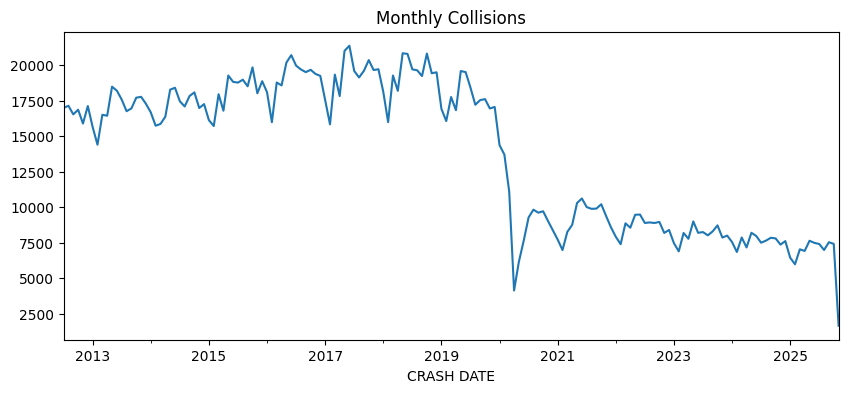

In [6]:
df = df_Collisions_Crashes.copy()
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
ts = df.set_index('CRASH DATE').resample('M').size()
ts.plot(title='Monthly Collisions', figsize=(10,4))

Hour-of-day vs day-of-week heatmap: find peak danger times.

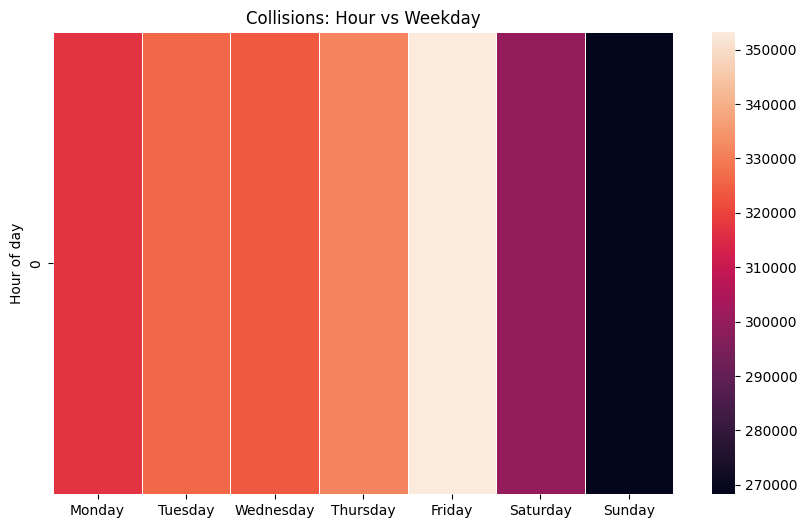

In [7]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df = df.dropna(subset=['CRASH DATE']).copy()
df['hour'] = df['CRASH DATE'].dt.hour
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['weekday'] = pd.Categorical(df['CRASH DATE'].dt.day_name(), categories=weekday_order, ordered=True)
pivot = df.groupby(['hour','weekday']).size().unstack(fill_value=0).reindex(columns=weekday_order).fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='rocket', linewidths=.5)
plt.title('Collisions: Hour vs Weekday')
plt.ylabel('Hour of day')
plt.xlabel('')
plt.show()

Map scatter (lat/lon): spatial density of collisions (cluster or heatmap).

In [8]:
import plotly.express as px
m = df_Collisions_Crashes.dropna(subset=['LATITUDE','LONGITUDE']).sample(n=min(20000, len(df_Collisions_Crashes)))
fig = px.scatter_mapbox(m, lat='LATITUDE', lon='LONGITUDE', color='BOROUGH',
                        hover_data=['CRASH DATE','CONTRIBUTING FACTOR VEHICLE 1'],
                        zoom=10, height=600)
fig.update_layout(mapbox_style='open-street-map')
fig.show()


Choropleth by borough or zip: collisions per area (requires geo boundaries).

# 1. Injuries/Fatalities by Borough (Stacked Bar)

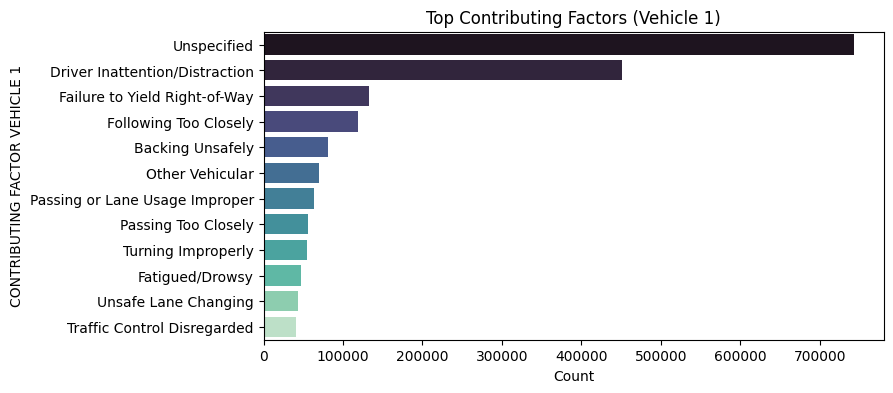

In [9]:
top = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(12)
plt.figure(figsize=(8,4))
sns.barplot(x=top.values, y=top.index, palette='mako')
plt.title('Top Contributing Factors (Vehicle 1)')
plt.xlabel('Count')
plt.show()

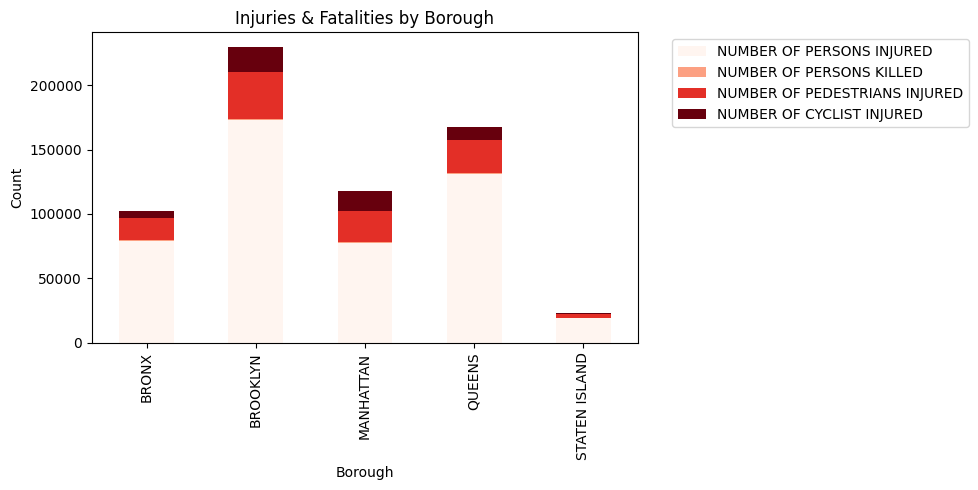

In [10]:
injury_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
               'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED']
borough_injuries = df_Collisions_Crashes.groupby('BOROUGH')[injury_cols].sum().fillna(0)
borough_injuries.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Reds')
plt.title('Injuries & Fatalities by Borough')
plt.ylabel('Count')
plt.xlabel('Borough')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

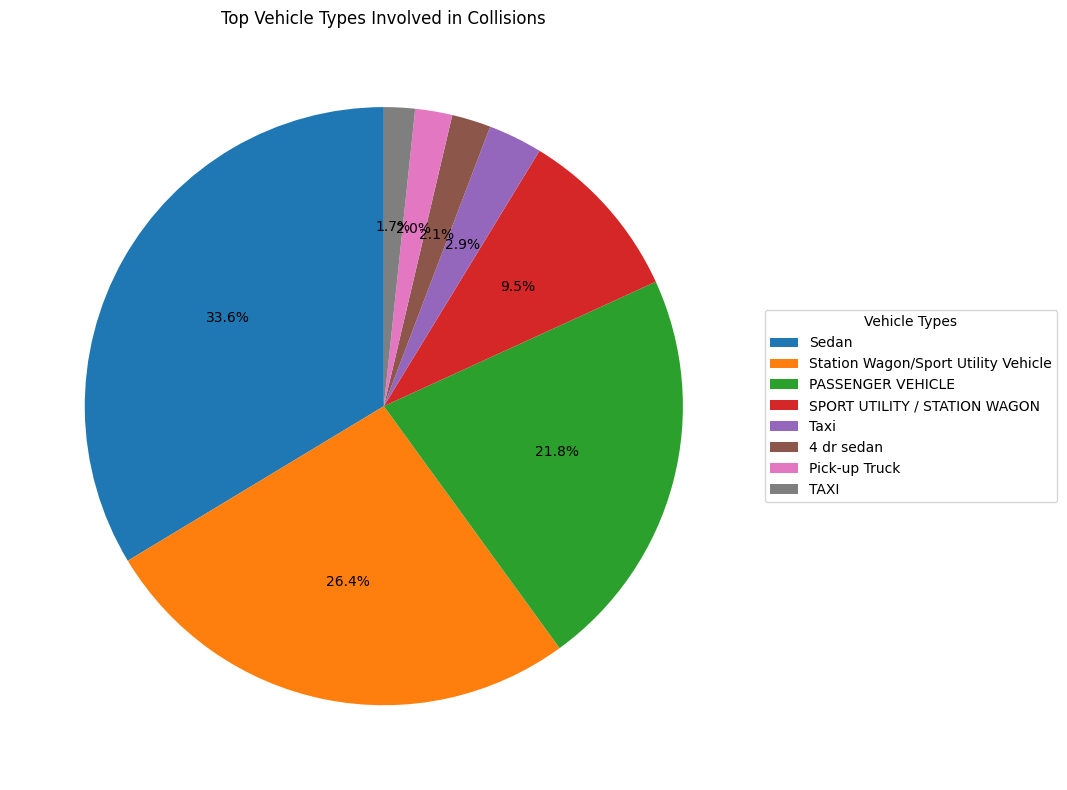

In [11]:
# ...existing code...
vehicle_types = df_Collisions_Crashes['VEHICLE TYPE CODE 1'].value_counts().head(8)
plt.figure(figsize=(10,8))
wedges, texts, autotexts = plt.pie(vehicle_types.values, autopct='%1.1f%%', startangle=90)
plt.title('Top Vehicle Types Involved in Collisions')
plt.legend(wedges, vehicle_types.index, title="Vehicle Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()
# ...existing code...

# 3. Contributing Factor vs Injuries (Scatter/Box Plot)

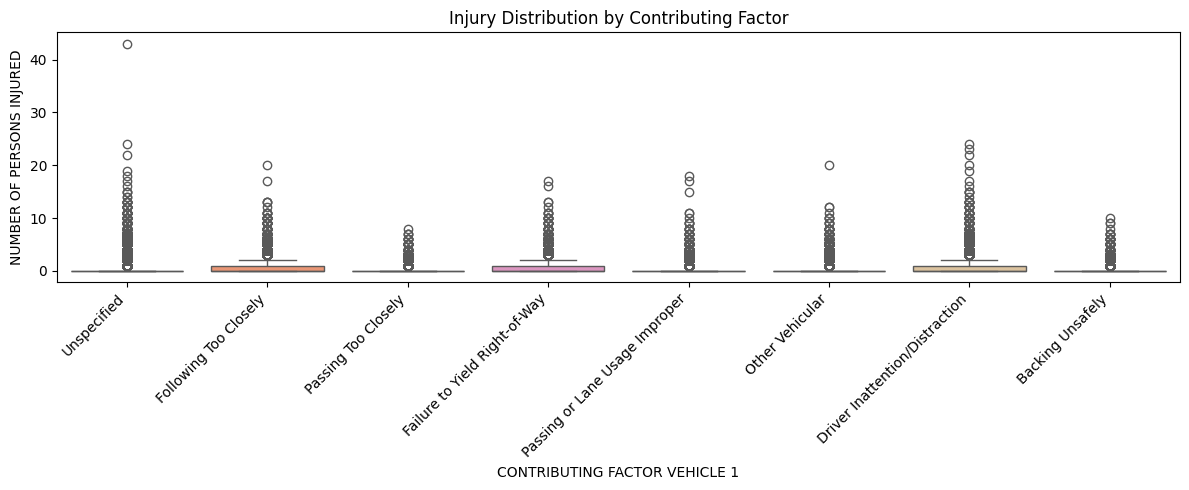

In [12]:
df_clean = df_Collisions_Crashes[df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].notna()].copy()
top_factors = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(8).index
df_factors = df_clean[df_clean['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_factors)]
plt.figure(figsize=(12,5))
sns.boxplot(data=df_factors, x='CONTRIBUTING FACTOR VEHICLE 1', y='NUMBER OF PERSONS INJURED', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Injury Distribution by Contributing Factor')
plt.tight_layout()
plt.show()

# 4. Time of Day vs Severity (Stacked Area)

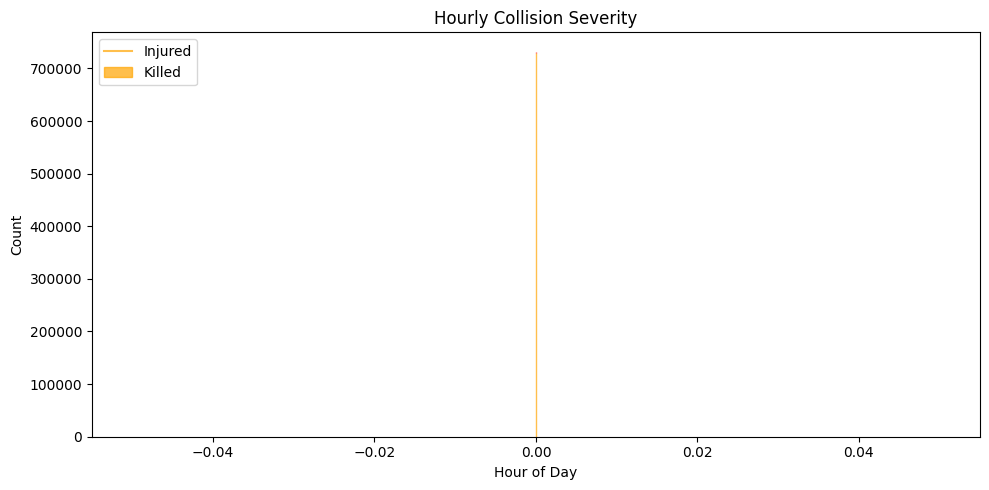

In [28]:
# 4. Time of Day vs Severity (Stacked Area)
df_time = df_Collisions_Crashes.copy()
df_time['CRASH DATE'] = pd.to_datetime(df_time['CRASH DATE'], errors='coerce')
df_time = df_time.dropna(subset=['CRASH DATE'])  # Added: drop rows with invalid dates
df_time['hour'] = df_time['CRASH DATE'].dt.hour
severity = df_time.groupby('hour')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
severity.plot(kind='area', stacked=True, figsize=(10,5), alpha=0.7, color=['orange','red'])
plt.title('Hourly Collision Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(['Injured', 'Killed'], loc='upper left')  # Added loc parameter for better placement
plt.tight_layout()  # Added for better layout
plt.show()

# 5. Correlation Heatmap (Numeric Features)

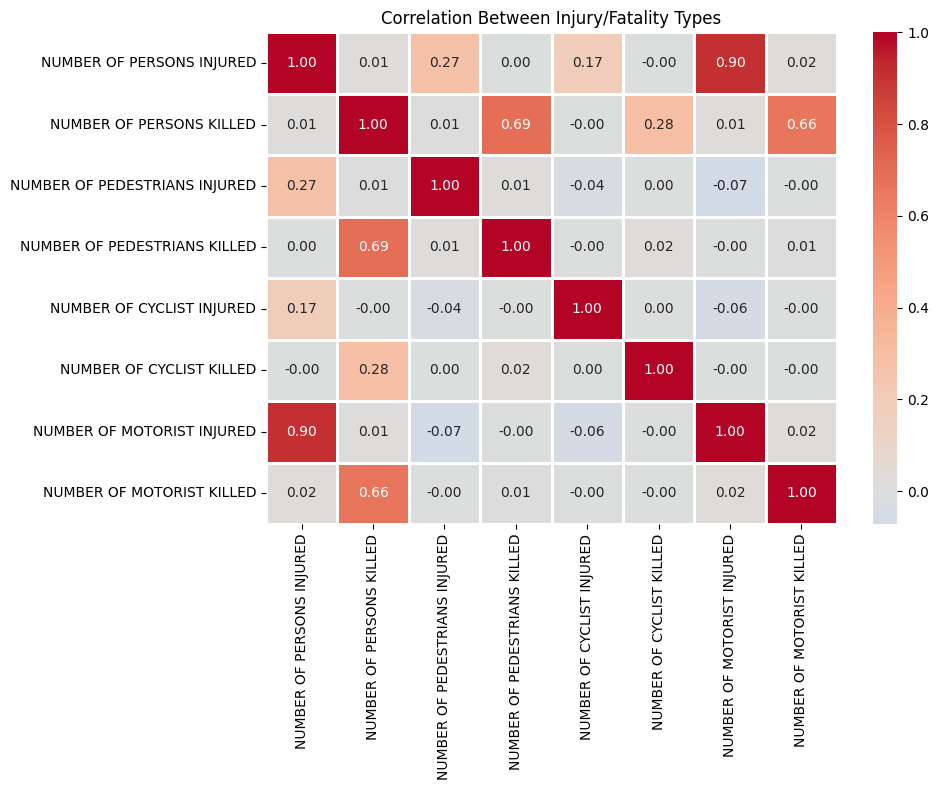

In [14]:
numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']
corr = df_Collisions_Crashes[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=1)
plt.title('Correlation Between Injury/Fatality Types')
plt.tight_layout()
plt.show()

# 6. Borough vs Contributing Factor (Grouped Bar)

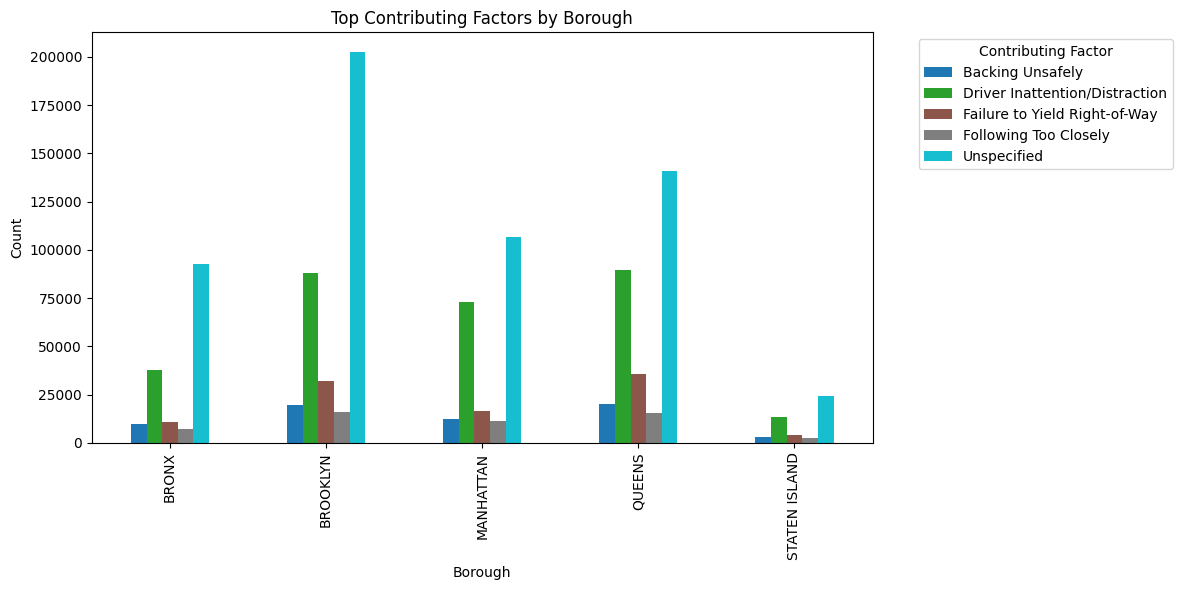

In [15]:
top_boroughs = df_Collisions_Crashes['BOROUGH'].value_counts().head(5).index
top_5_factors = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(5).index
df_cross = df_Collisions_Crashes[(df_Collisions_Crashes['BOROUGH'].isin(top_boroughs)) & 
                                  (df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_5_factors))]
cross_tab = pd.crosstab(df_cross['BOROUGH'], df_cross['CONTRIBUTING FACTOR VEHICLE 1'])
cross_tab.plot(kind='bar', figsize=(12,6), colormap='tab10')
plt.title('Top Contributing Factors by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.legend(title='Contributing Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. Interactive Time Series with Plotly (Daily Collisions)

In [16]:
df_daily = df_Collisions_Crashes.copy()
df_daily['CRASH DATE'] = pd.to_datetime(df_daily['CRASH DATE'], errors='coerce')
daily_counts = df_daily.groupby(df_daily['CRASH DATE'].dt.date).size().reset_index(name='Count')
daily_counts.columns = ['Date', 'Collisions']
fig = px.line(daily_counts, x='Date', y='Collisions', title='Daily Collision Trend')
fig.update_traces(line_color='steelblue')
fig.show()

# 8. Violin Plot: Injuries by Day of Week

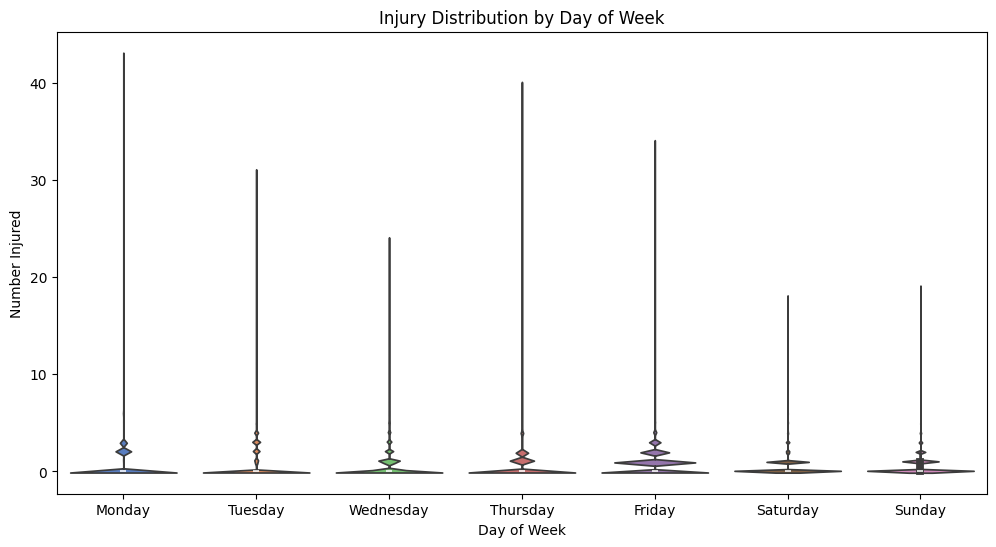

In [17]:
df_violin = df_Collisions_Crashes.copy()
df_violin['CRASH DATE'] = pd.to_datetime(df_violin['CRASH DATE'], errors='coerce')
df_violin = df_violin.dropna(subset=['CRASH DATE'])
df_violin['weekday'] = df_violin['CRASH DATE'].dt.day_name()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(12,6))
sns.violinplot(data=df_violin, x='weekday', y='NUMBER OF PERSONS INJURED', 
               order=weekday_order, palette='muted')
plt.title('Injury Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number Injured')
plt.show()

# 9. Street Name Analysis - Top Dangerous Streets

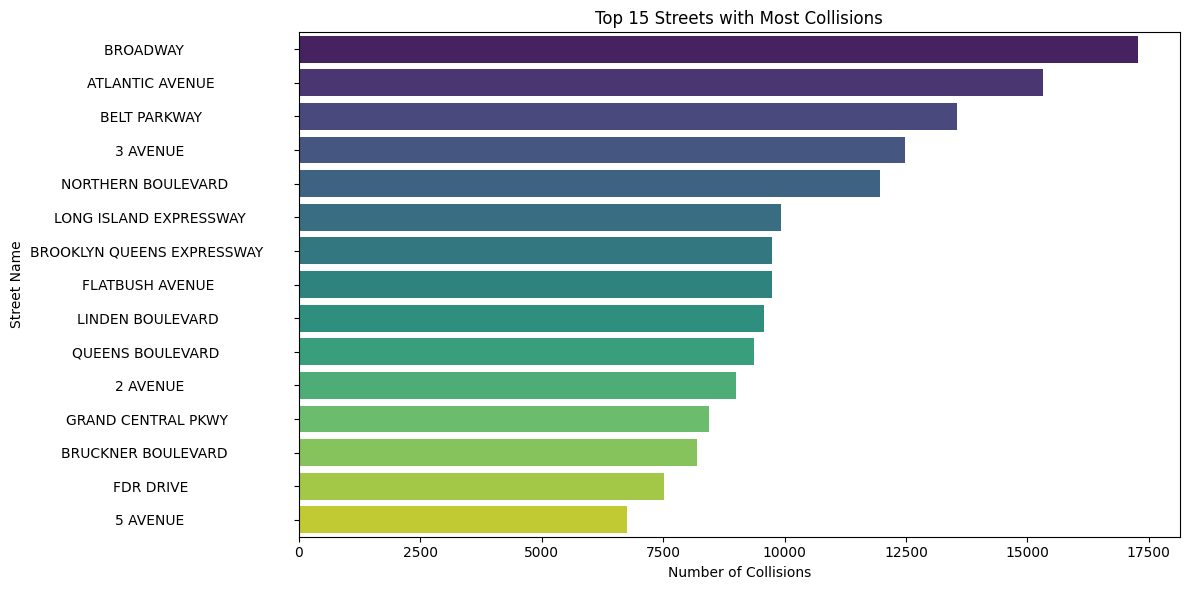

In [18]:
top_streets = df_Collisions_Crashes['ON STREET NAME'].value_counts().head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=top_streets.values, y=top_streets.index, palette='viridis')
plt.title('Top 15 Streets with Most Collisions')
plt.xlabel('Number of Collisions')
plt.ylabel('Street Name')
plt.tight_layout()
plt.show()

# 10. Monthly Trend by Borough (Line Chart)

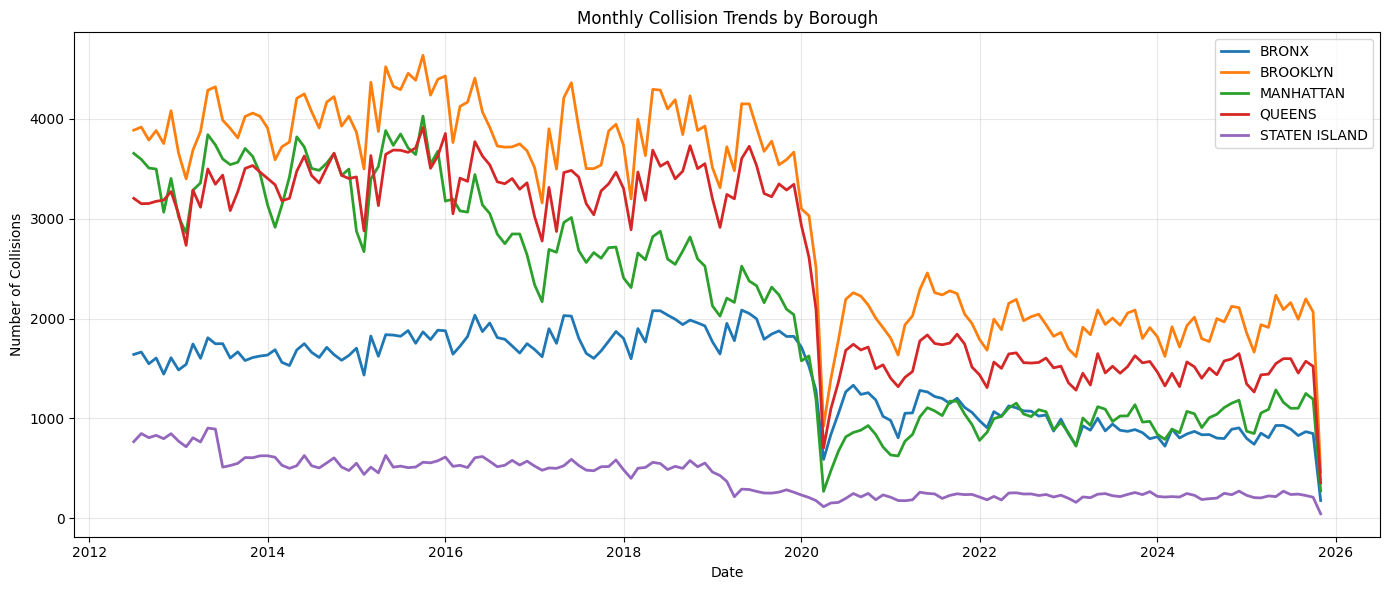

In [19]:
df_borough_time = df_Collisions_Crashes.copy()
df_borough_time['CRASH DATE'] = pd.to_datetime(df_borough_time['CRASH DATE'], errors='coerce')
df_borough_time = df_borough_time.dropna(subset=['CRASH DATE', 'BOROUGH'])
df_borough_time['month'] = df_borough_time['CRASH DATE'].dt.to_period('M')
monthly_borough = df_borough_time.groupby(['month', 'BOROUGH']).size().unstack(fill_value=0)
monthly_borough.index = monthly_borough.index.to_timestamp()
plt.figure(figsize=(14,6))
for col in monthly_borough.columns:
    plt.plot(monthly_borough.index, monthly_borough[col], label=col, linewidth=2)
plt.title('Monthly Collision Trends by Borough')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 11. Injury Severity Funnel Chart

In [20]:
severity_data = pd.DataFrame({
    'Category': ['Total Collisions', 'With Injuries', 'With Deaths'],
    'Count': [
        len(df_Collisions_Crashes),
        df_Collisions_Crashes[df_Collisions_Crashes['NUMBER OF PERSONS INJURED'] > 0].shape[0],
        df_Collisions_Crashes[df_Collisions_Crashes['NUMBER OF PERSONS KILLED'] > 0].shape[0]
    ]
})
fig = px.funnel(severity_data, x='Count', y='Category', title='Collision Severity Funnel')
fig.show()

# 12. Contributing Factor Word Cloud (Top 30)

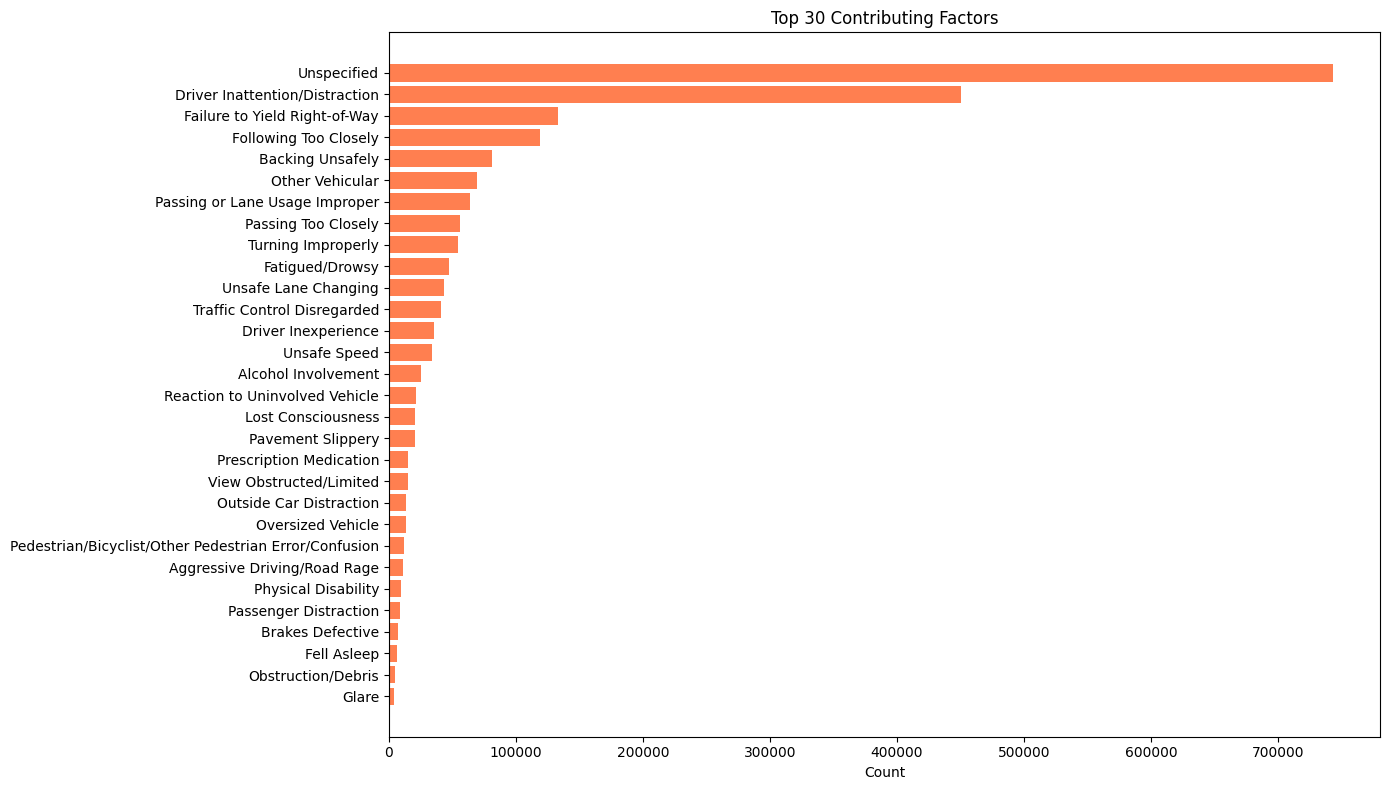

In [21]:
from collections import Counter
factors = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].dropna()
factor_counts = Counter(factors)
top_30 = dict(factor_counts.most_common(30))
plt.figure(figsize=(14,8))
plt.barh(list(top_30.keys())[::-1], list(top_30.values())[::-1], color='coral')
plt.title('Top 30 Contributing Factors')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# 14. Zip Code Heatmap (Top 20 Zip Codes)

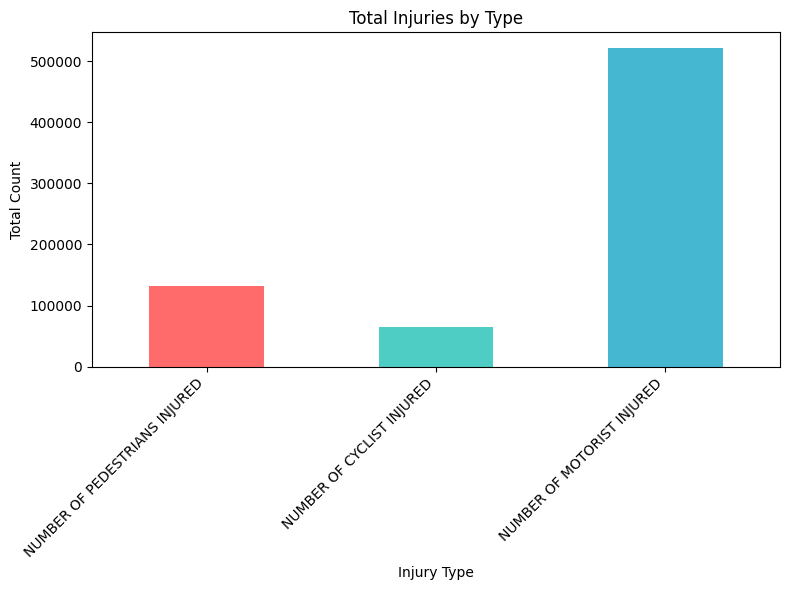

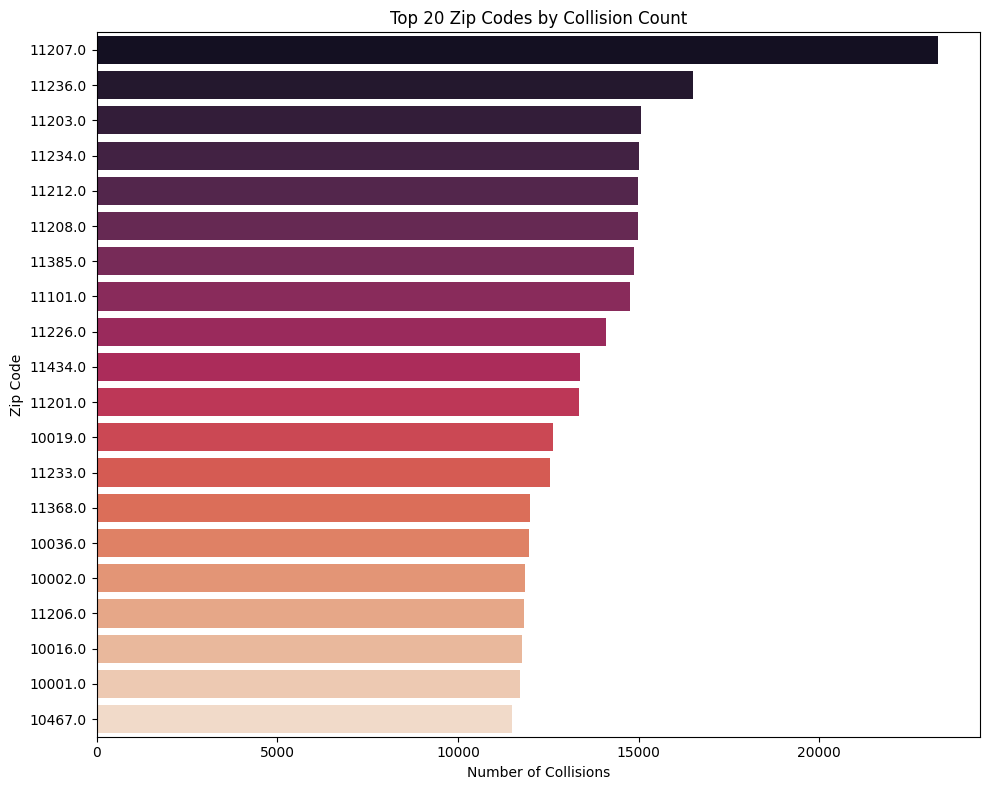

In [22]:
injury_comparison = df_Collisions_Crashes[['NUMBER OF PEDESTRIANS INJURED', 
                                             'NUMBER OF CYCLIST INJURED', 
                                             'NUMBER OF MOTORIST INJURED']].sum()
plt.figure(figsize=(8,6))
injury_comparison.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Total Injuries by Type')
plt.xlabel('Injury Type')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 14. Zip Code Heatmap (Top 20 Zip Codes)
zip_collisions = df_Collisions_Crashes['ZIP CODE'].value_counts().head(20)
plt.figure(figsize=(10,8))
sns.barplot(y=zip_collisions.index.astype(str), x=zip_collisions.values, palette='rocket')
plt.title('Top 20 Zip Codes by Collision Count')
plt.xlabel('Number of Collisions')
plt.ylabel('Zip Code')
plt.tight_layout()
plt.show()

# 15. Multi-Vehicle Involvement Analysis

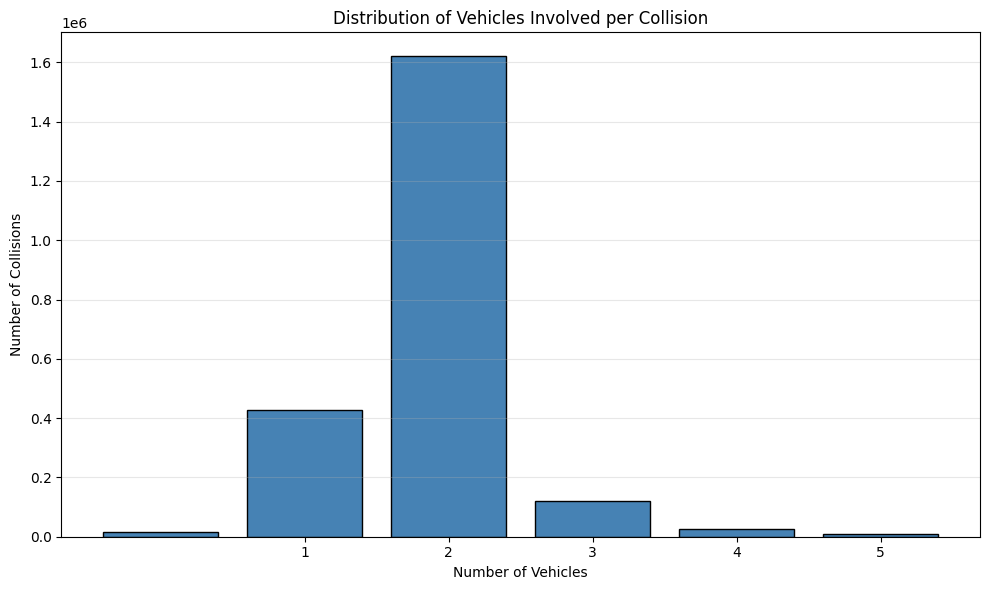

In [23]:
df_Collisions_Crashes['vehicle_count'] = df_Collisions_Crashes[['VEHICLE TYPE CODE 1', 
                                                                   'VEHICLE TYPE CODE 2', 
                                                                   'VEHICLE TYPE CODE 3', 
                                                                   'VEHICLE TYPE CODE 4', 
                                                                   'VEHICLE TYPE CODE 5']].notna().sum(axis=1)
vehicle_dist = df_Collisions_Crashes['vehicle_count'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(vehicle_dist.index, vehicle_dist.values, color='steelblue', edgecolor='black')
plt.title('Distribution of Vehicles Involved per Collision')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Collisions')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 16. Fatality Rate by Borough (Percentage)

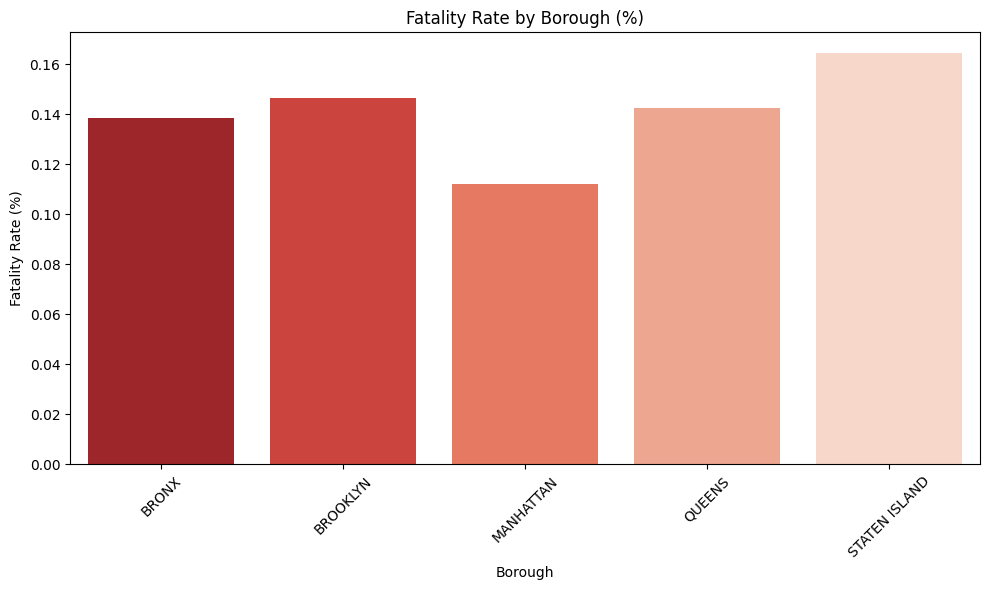

In [24]:
borough_stats = df_Collisions_Crashes.groupby('BOROUGH').agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'COLLISION_ID': 'count'
}).rename(columns={'COLLISION_ID': 'total_collisions'})
borough_stats['fatality_rate'] = (borough_stats['NUMBER OF PERSONS KILLED'] / 
                                    borough_stats['total_collisions'] * 100)
plt.figure(figsize=(10,6))
sns.barplot(x=borough_stats.index, y=borough_stats['fatality_rate'], palette='Reds_r')
plt.title('Fatality Rate by Borough (%)')
plt.xlabel('Borough')
plt.ylabel('Fatality Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 18. Year-over-Year Comparison

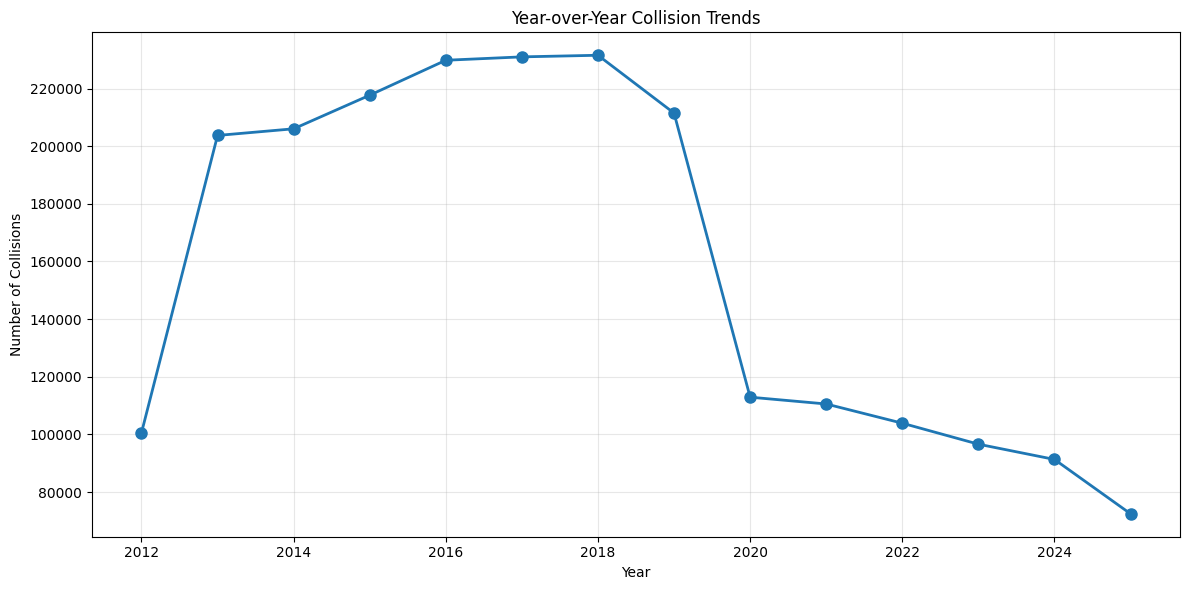

In [25]:
df_yoy = df_Collisions_Crashes.copy()
df_yoy['CRASH DATE'] = pd.to_datetime(df_yoy['CRASH DATE'], errors='coerce')
df_yoy = df_yoy.dropna(subset=['CRASH DATE'])
df_yoy['year'] = df_yoy['CRASH DATE'].dt.year
yearly_counts = df_yoy.groupby('year').size()
plt.figure(figsize=(12,6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
plt.title('Year-over-Year Collision Trends')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

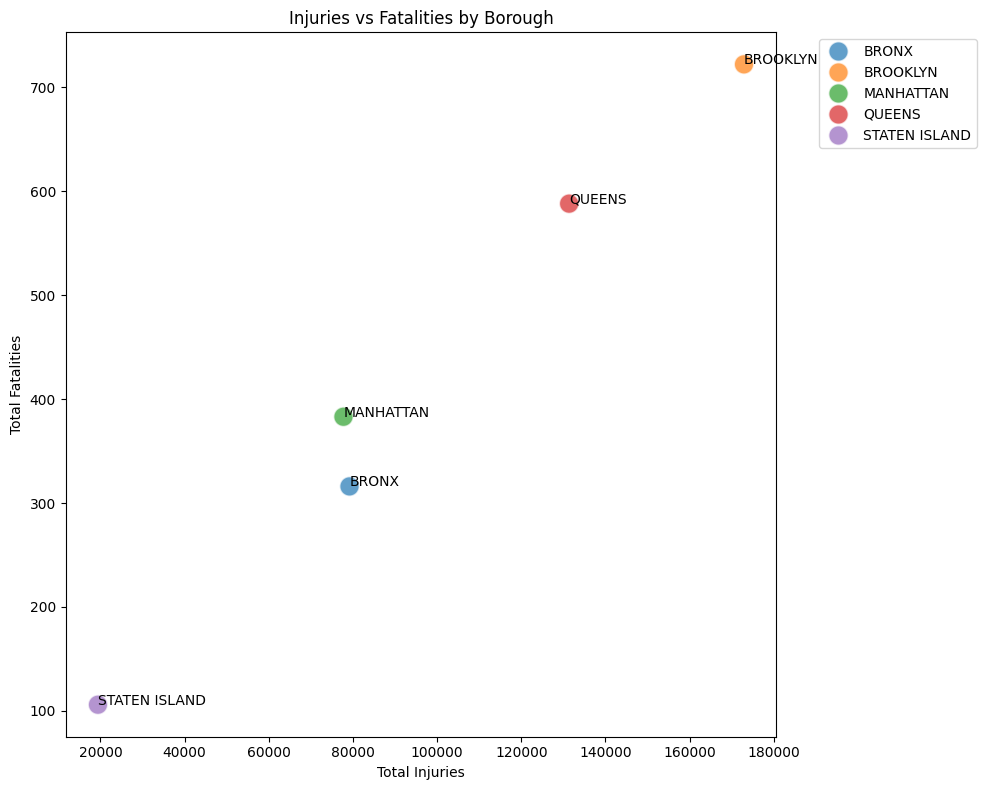

In [26]:
borough_scatter = df_Collisions_Crashes.groupby('BOROUGH').agg({
    'NUMBER OF PERSONS INJURED': 'sum',
    'NUMBER OF PERSONS KILLED': 'sum'
}).reset_index()
plt.figure(figsize=(10,8))
sns.scatterplot(data=borough_scatter, x='NUMBER OF PERSONS INJURED', 
                y='NUMBER OF PERSONS KILLED', hue='BOROUGH', s=200, alpha=0.7)
for i, row in borough_scatter.iterrows():
    plt.annotate(row['BOROUGH'], (row['NUMBER OF PERSONS INJURED'], 
                 row['NUMBER OF PERSONS KILLED']), fontsize=10)
plt.title('Injuries vs Fatalities by Borough')
plt.xlabel('Total Injuries')
plt.ylabel('Total Fatalities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

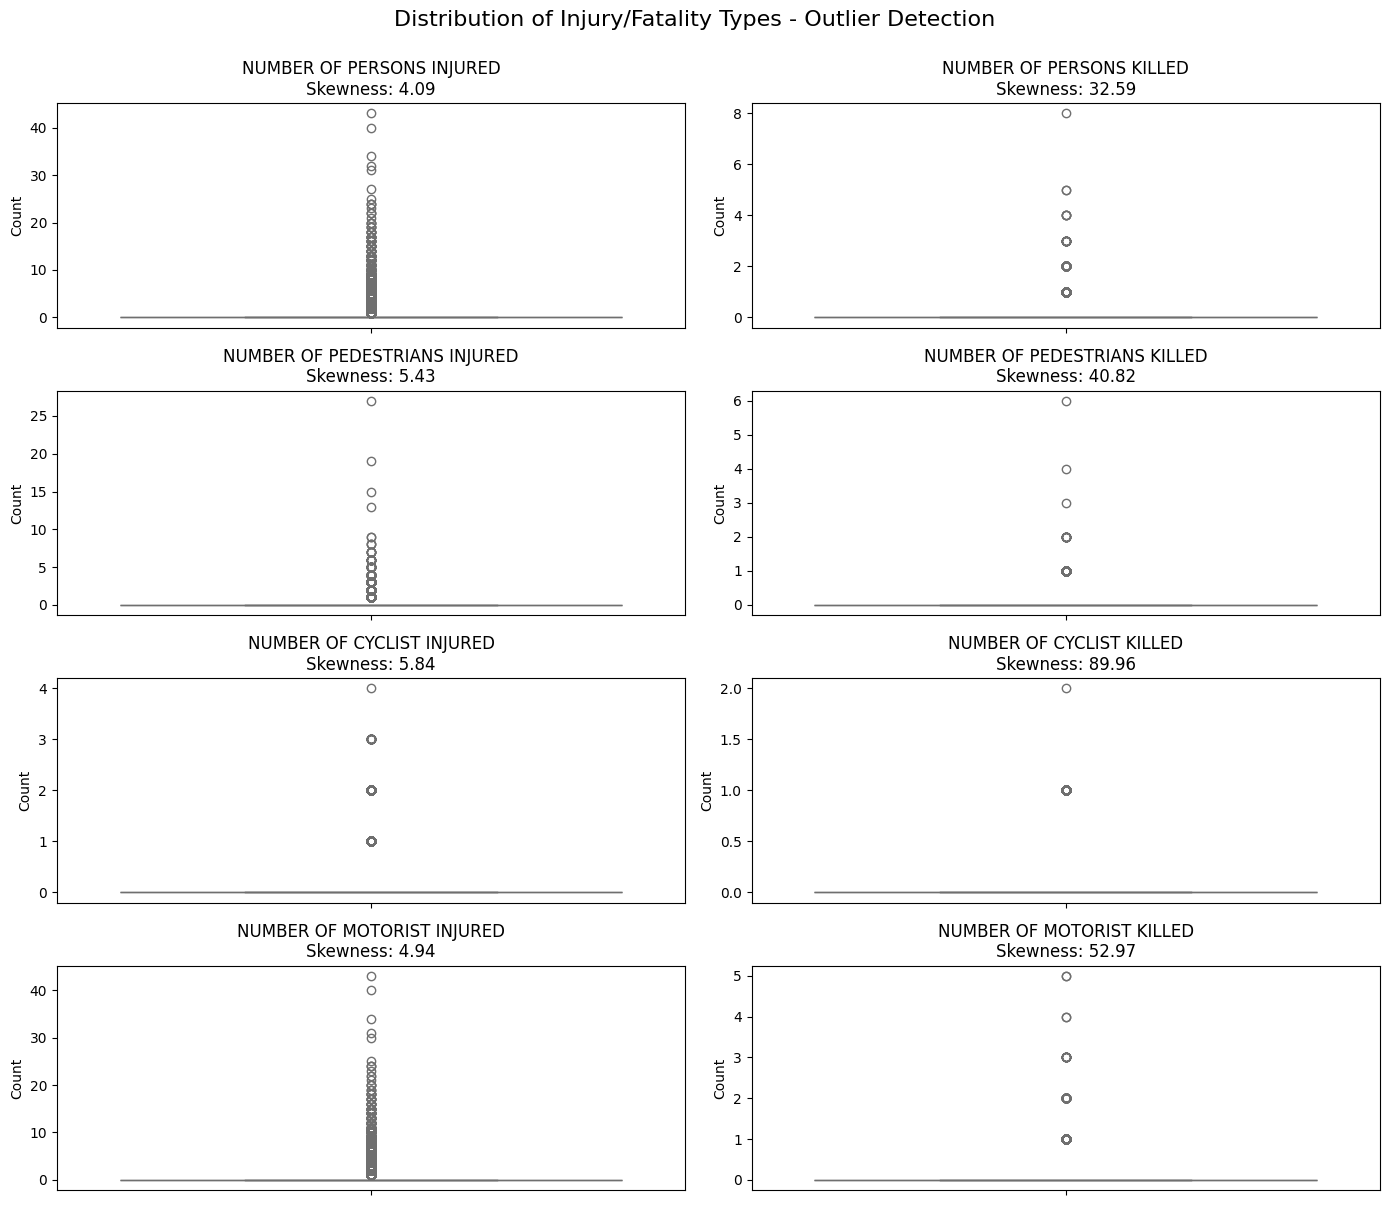

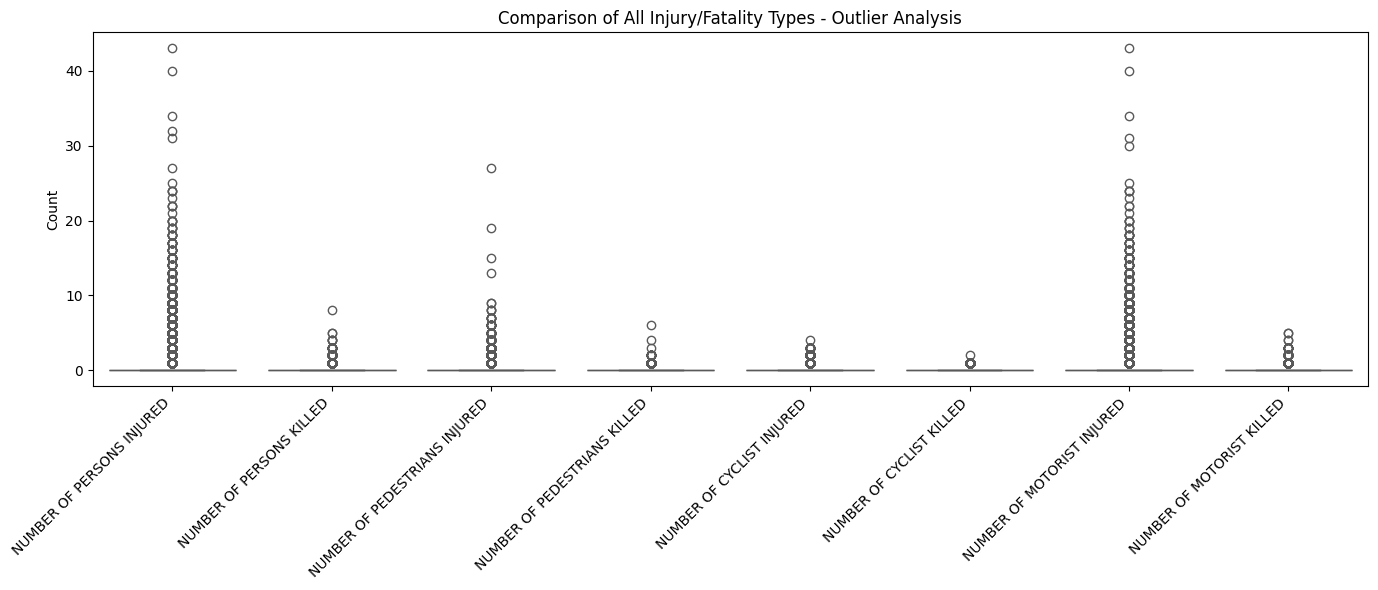

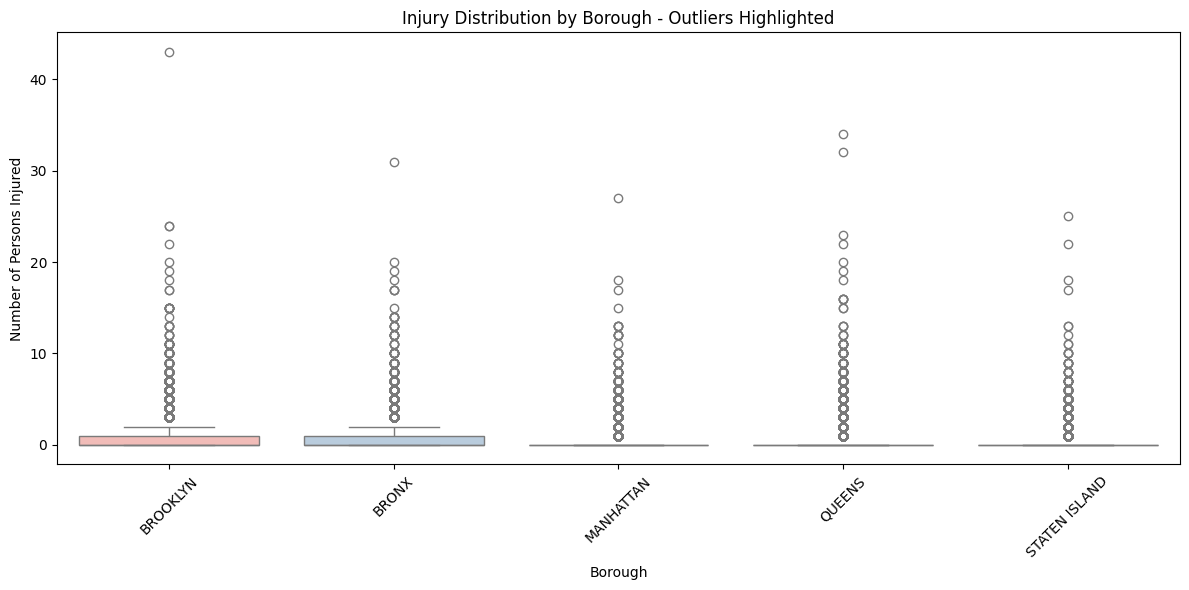

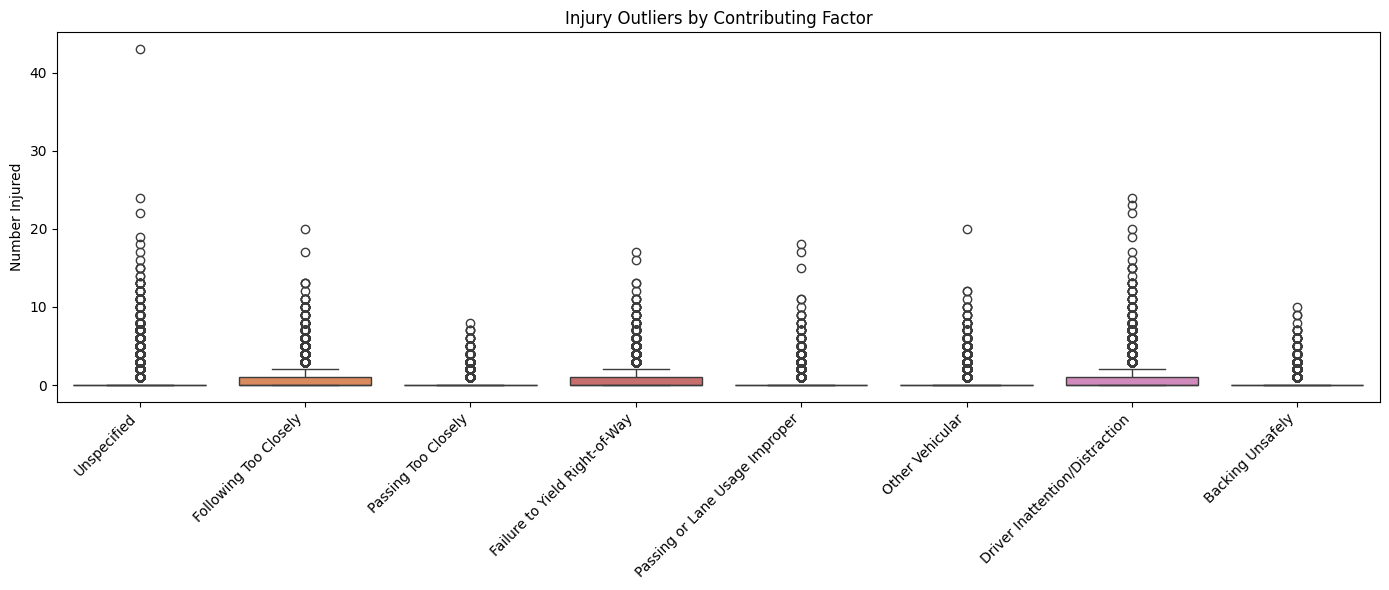


=== Outlier Analysis Summary ===
                       Column     Mean  Median  Std Dev  Skewness  Outliers  Outlier %
    NUMBER OF PERSONS INJURED 0.328196     0.0 0.714920  4.089456    537788  24.228428
     NUMBER OF PERSONS KILLED 0.001585     0.0 0.042064 32.591864      3372   0.151915
NUMBER OF PEDESTRIANS INJURED 0.059590     0.0 0.250040  5.429893    126819   5.713450
 NUMBER OF PEDESTRIANS KILLED 0.000784     0.0 0.028632 40.820353      1715   0.077264
    NUMBER OF CYCLIST INJURED 0.029181     0.0 0.170583  5.841433     63945   2.880851
     NUMBER OF CYCLIST KILLED 0.000126     0.0 0.011271 89.961176       279   0.012570
   NUMBER OF MOTORIST INJURED 0.234785     0.0 0.676068  4.941301    340764  15.352102
    NUMBER OF MOTORIST KILLED 0.000645     0.0 0.027781 52.965930      1322   0.059559


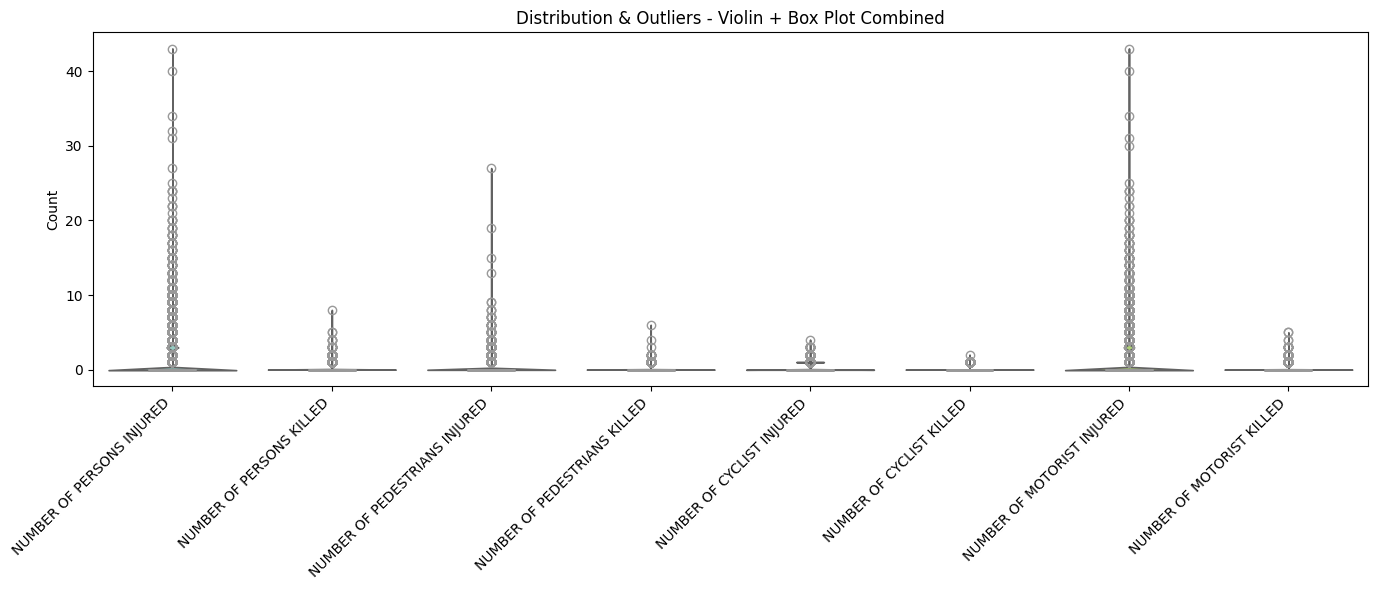

In [27]:
# Box Plots for Numerical Features - Show Skewness & Outliers

# 1. Individual Box Plots for Each Injury/Fatality Type
numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df_Collisions_Crashes, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{col}\nSkewness: {df_Collisions_Crashes[col].skew():.2f}')
    axes[idx].set_ylabel('Count')
    
plt.suptitle('Distribution of Injury/Fatality Types - Outlier Detection', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# 2. Combined Box Plot - All Injury Types Side by Side
plt.figure(figsize=(14, 6))
df_melted = df_Collisions_Crashes[numeric_cols].melt(var_name='Injury Type', value_name='Count')
sns.boxplot(data=df_melted, x='Injury Type', y='Count', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of All Injury/Fatality Types - Outlier Analysis')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

# 3. Box Plot by Borough - Injuries
plt.figure(figsize=(12, 6))
df_box = df_Collisions_Crashes.dropna(subset=['BOROUGH', 'NUMBER OF PERSONS INJURED'])
sns.boxplot(data=df_box, x='BOROUGH', y='NUMBER OF PERSONS INJURED', palette='Pastel1')
plt.title('Injury Distribution by Borough - Outliers Highlighted')
plt.xlabel('Borough')
plt.ylabel('Number of Persons Injured')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Box Plot by Contributing Factor (Top 8)
df_clean = df_Collisions_Crashes[df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].notna()].copy()
top_factors = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(8).index
df_factors = df_clean[df_clean['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_factors)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_factors, x='CONTRIBUTING FACTOR VEHICLE 1', y='NUMBER OF PERSONS INJURED', palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Injury Outliers by Contributing Factor')
plt.xlabel('')
plt.ylabel('Number Injured')
plt.tight_layout()
plt.show()

# 5. Statistical Summary with Outlier Count
outlier_summary = []
for col in numeric_cols:
    Q1 = df_Collisions_Crashes[col].quantile(0.25)
    Q3 = df_Collisions_Crashes[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_Collisions_Crashes[(df_Collisions_Crashes[col] < lower_bound) | 
                                       (df_Collisions_Crashes[col] > upper_bound)][col].count()
    
    outlier_summary.append({
        'Column': col,
        'Mean': df_Collisions_Crashes[col].mean(),
        'Median': df_Collisions_Crashes[col].median(),
        'Std Dev': df_Collisions_Crashes[col].std(),
        'Skewness': df_Collisions_Crashes[col].skew(),
        'Outliers': outliers,
        'Outlier %': (outliers / len(df_Collisions_Crashes) * 100)
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n=== Outlier Analysis Summary ===")
print(outlier_df.to_string(index=False))

# 6. Violin Plot with Box Plot Overlay - Shows Distribution + Outliers
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_melted, x='Injury Type', y='Count', palette='Set3', inner=None)
sns.boxplot(data=df_melted, x='Injury Type', y='Count', width=0.3, color='white', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution & Outliers - Violin + Box Plot Combined')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()